# Datastory titel

introductie. 

## kopje argument 1

tekst die erbij hoort: introductie tot het argument ect.

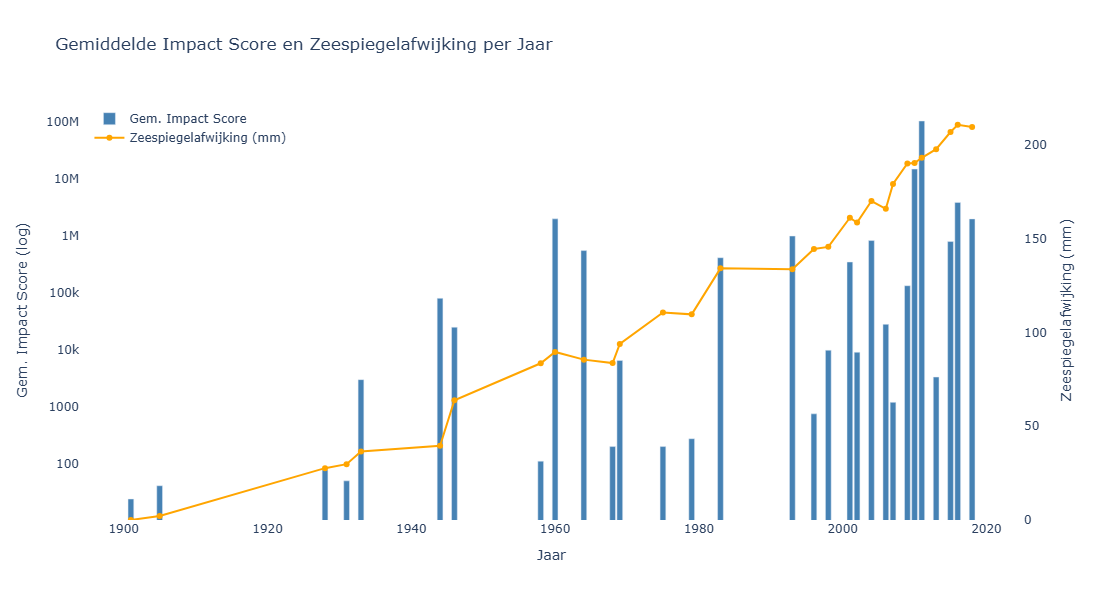

In [49]:

import plotly.graph_objs as go
import plotly.express as px
import pandas as pd

from plotly.offline import init_notebook_mode
init_notebook_mode(connected=True)
sea_level_df = pd.read_csv("Global_sea_level_rise.csv")

sea_df = pd.read_csv('Global_sea_level_rise.csv')
dist_df = pd.read_csv('1900_2021_DISASTERS.xlsx - emdat data.csv')

tsunami_df = dist_df[dist_df['Disaster Subtype'].str.lower() == 'tsunami'].copy()
flood_df = dist_df[dist_df['Disaster Subtype'].str.lower() == 'flood'].copy()

tsunami_df.columns = tsunami_df.columns.str.strip()
flood_df.columns = flood_df.columns.str.strip()
sea_df.rename(columns={'year': 'Year'}, inplace=True)

#subsets om samen te voegen
tsunami_subset = tsunami_df[['Year', 'Disaster Subtype', 'Country', 'Region', 'Continent', 'Origin', 'River Basin',
                             'Total Deaths', 'Total Affected', "Total Damages ('000 US$)", 'Latitude', 'Longitude', 'Location']]

flood_subset = flood_df[['Year', 'Disaster Subtype', 'Country', 'Region', 'Continent', 'Origin', 'River Basin',
                         'Total Deaths', 'Total Affected', "Total Damages ('000 US$)", 'Latitude', 'Longitude', 'Location']]

#eerste twee samen voegen
disaster_df = pd.concat([tsunami_subset, flood_subset], ignore_index=True)

#laatste samenvoegen
merged_df = disaster_df.merge(sea_df[['Year', 'mmfrom1993-2008average']], on='Year', how='left')

#missende waardes invullen met 0
merged_df = merged_df.fillna(0)

import numpy as np 
merged_df['Total Deaths'] = pd.to_numeric(merged_df['Total Deaths'], errors='coerce').fillna(0)
merged_df['Total Affected'] = pd.to_numeric(merged_df['Total Affected'], errors='coerce').fillna(0)
merged_df["Total Damages ('000 US$)"] = pd.to_numeric(merged_df["Total Damages ('000 US$)"], errors='coerce').fillna(0)

merged_df['Impact_Score'] = merged_df[['Total Deaths', 'Total Affected', "Total Damages ('000 US$)"]].max(axis=1)

merged_df = merged_df[(merged_df['Latitude'] != 0) & (merged_df['Longitude'] != 0)]

filtered_df = merged_df[merged_df['Impact_Score'] > 0].copy()

filtered_df['Impact_Score_Log'] = filtered_df['Impact_Score'].apply(lambda x: np.log10(x + 1))

filtered_df['Year'] = pd.to_numeric(filtered_df['Year'], errors='coerce')
filtered_df = filtered_df.dropna(subset=['Year'])
filtered_df = filtered_df.sort_values('Year')
filtered_df['Year'] = filtered_df['Year'].astype(int)


avg_impact_per_year = filtered_df.groupby('Year')['Impact_Score'].mean().reset_index()

fig = go.Figure()


fig.add_trace(go.Bar(
    x=avg_impact_per_year['Year'],
    y=avg_impact_per_year['Impact_Score'],
    name='Gem. Impact Score',
    marker_color='steelblue',
    yaxis='y1',
    hovertemplate='Jaar: %{x}<br>Gem. Impact Score: %{y}<extra></extra>'
))
# Maak zeespiegelwaarden relatief t.o.v. het eerste jaar
first_year = filtered_df['Year'].min()
baseline = filtered_df.loc[filtered_df['Year'] == first_year, 'mmfrom1993-2008average'].values[0]
filtered_df['mmfrom1993-2008average'] = filtered_df['mmfrom1993-2008average'] - baseline

sea_level_data = filtered_df[['Year', 'mmfrom1993-2008average']].drop_duplicates()

fig.add_trace(go.Scatter(
    x=sea_level_data['Year'],
    y=sea_level_data['mmfrom1993-2008average'],
    name='Zeespiegelafwijking (mm)',
    mode='lines+markers',
    line=dict(color='orange', width=2),
    yaxis='y2',
    hovertemplate='Jaar: %{x}<br>Zeespiegelafwijking: %{y} mm<extra></extra>'
))

fig.update_layout(
    title="Gemiddelde Impact Score en Zeespiegelafwijking per Jaar",
    xaxis=dict(title='Jaar'),
    yaxis=dict(
        title='Gem. Impact Score',
        showgrid=False,
        side='left',
        rangemode='tozero'
    ),
    yaxis2=dict(
        title='Zeespiegelafwijking (mm)',
        overlaying='y',
        side='right',
        showgrid=False,
        rangemode='tozero'
    ),
    legend=dict(x=0.01, y=0.99),
    height=600,
    plot_bgcolor='white'
)

fig.update_layout(
    yaxis=dict(
        title='Gem. Impact Score (log)',
        type='log', 
        showgrid=False,
        side='left',
        rangemode='tozero'
    ),
)

fig.show()


argumentatie aan de hand van plot.

## Schade aan verwoestingen na een Tsunami
De stijgende zeespiegel wordt vaak genoemd als een van de meest directe gevolgen van klimaatverandering. In kustgebieden leidt deze ontwikkeling niet alleen tot een verhoogd risico op overstromingen, maar ook tot zwaardere gevolgen bij natuurrampen zoals tsunami’s. Een van de zichtbare effecten hiervan is de toename van de schade die tsunami’s aanrichten, een ontwikkeling die samen lijkt te hangen met de mondiale zeespiegelstijging. Dat verband wordt zichtbaar in de ruimtelijke spreiding van tsunami-gerelateerde schade (Plot 2). 

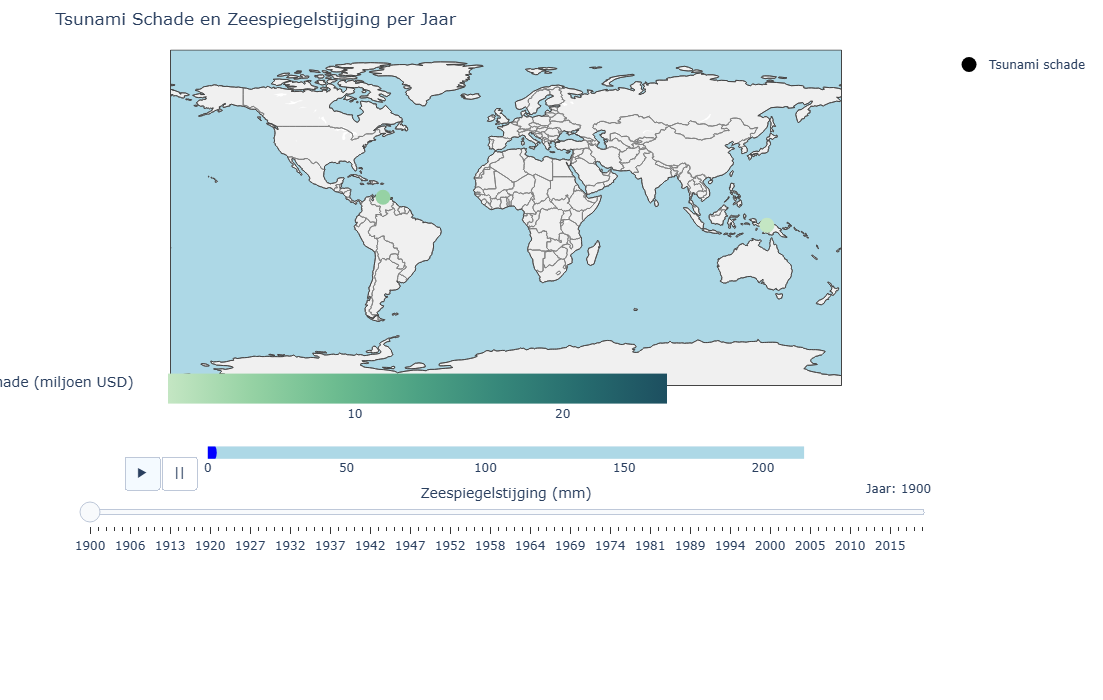

In [79]:
import pandas as pd
import plotly.graph_objects as go
import re

# Data inladen
tsunami_df = pd.read_csv("tsunami_dataset.csv")
sea_level_df = pd.read_csv("Global_sea_level_rise.csv")

# Schoonmaken tsunami data
tsunami_df = tsunami_df[['YEAR', 'DAMAGE_TOTAL_DESCRIPTION', 'COUNTRY', 'LONGITUDE', 'LATITUDE','DEATHS_TOTAL_DESCRIPTION', 'HOUSES_TOTAL_DESCRIPTION']].dropna()
tsunami_df['YEAR'] = tsunami_df['YEAR'].astype(int)

# Schoonmaken zeespiegel data
sea_level_df = sea_level_df.rename(columns={'year': 'Year', 'mmfrom1993-2008average': 'Sea_Level_Change_mm'})
sea_level_df['Year'] = sea_level_df['Year'].astype(int)
sea_level_df = sea_level_df.sort_values('Year')

# Baseline 1900 bepalen
if 1900 in sea_level_df['Year'].values:
    baseline = sea_level_df.loc[sea_level_df['Year'] == 1900, 'Sea_Level_Change_mm'].values[0]
else:
    closest_year = sea_level_df.iloc[(sea_level_df['Year'] - 1900).abs().argsort()[:1]]['Year'].values[0]
    baseline = sea_level_df.loc[sea_level_df['Year'] == closest_year, 'Sea_Level_Change_mm'].values[0]

sea_level_df['Sea_Level_Change_mm'] = sea_level_df['Sea_Level_Change_mm'] - baseline

# Zeespiegel smoothen met rolling average over 5 jaar
sea_level_df['Sea_Level_Change_mm'] = sea_level_df['Sea_Level_Change_mm'].rolling(window=5, center=True, min_periods=1).mean()

# Merge datasets en filter vanaf 1900
merged = pd.merge(tsunami_df, sea_level_df, left_on='YEAR', right_on='Year', how='inner')
merged = merged[merged['YEAR'] >= 1900].copy()

# Schadebedrag parseren
def parse_damage_amount(description):
    if not isinstance(description, str):
        return 0
    description = description.lower().replace(",", "")
    match = re.search(r'([\d\.]+)\s*(billion|million|thousand)?', description)
    if match:
        amount = float(match.group(1))
        unit = match.group(2)
        if unit == 'billion':
            return amount * 1_000
        elif unit == 'million':
            return amount
        elif unit == 'thousand':
            return amount / 1_000
        else:
            return amount
    return 0

merged['Estimated_Damage_MillionUSD'] = merged['DAMAGE_TOTAL_DESCRIPTION'].apply(parse_damage_amount).round(1)
merged['Sea_Level_Change_mm'] = merged['Sea_Level_Change_mm'].round(2)

min_sea = 0
max_sea = merged['Sea_Level_Change_mm'].max()
min_damage = merged['Estimated_Damage_MillionUSD'].min()
max_damage = merged['Estimated_Damage_MillionUSD'].max()

years = sorted(merged['YEAR'].unique())
jaar_0 = years[0]
df_year_0 = merged[merged['YEAR'] == jaar_0]

# Schade-intervals instellen in stappen van 10 miljoen (of groter als nodig)
step_size = max(10, int((max_damage - min_damage) / 10))
schade_ticks = list(range(0, int(max_damage) + step_size, step_size))

fig = go.Figure()

# Wereldkaart tsunami schade (Scattergeo) met coloraxis
fig.add_trace(go.Scattergeo(
    lon=df_year_0['LONGITUDE'],
    lat=df_year_0['LATITUDE'],
    text=df_year_0['COUNTRY'] + "<br>Schade: " + df_year_0['Estimated_Damage_MillionUSD'].astype(str) + " M$",
    marker=dict(
        color=df_year_0['Estimated_Damage_MillionUSD'],
        colorscale='OrRd',
        cmin=min_damage,
        cmax=max_damage,
        size=15,  # bollen groter gemaakt
        colorbar=None
    ),
    name='Tsunami schade',
    hoverinfo='text'
))

# Schadekleurbalk wordt via coloraxis toegevoegd in layout

# Zeespiegelbalk (lijn + bolletje)
fig.add_trace(go.Scatter(
    x=[min_sea, max_sea],
    y=[0, 0],
    mode='lines',
    line=dict(color='lightblue', width=20),
    showlegend=False,
    xaxis='x2',
    yaxis='y2'
))
fig.add_trace(go.Scatter(
    x=[merged[merged['YEAR'] == jaar_0]['Sea_Level_Change_mm'].mean()],
    y=[0],
    mode='markers',
    marker=dict(size=30, color='blue'),  # bollen groter gemaakt
    showlegend=False,
    xaxis='x2',
    yaxis='y2'
))

# Frames voor animatie
frames = []
for year in years:
    df_year = merged[merged['YEAR'] == year]
    sea_val = df_year['Sea_Level_Change_mm'].mean()
    frames.append(go.Frame(
        data=[
            go.Scattergeo(
                lon=df_year['LONGITUDE'],
                lat=df_year['LATITUDE'],
                marker=dict(color=df_year['Estimated_Damage_MillionUSD'], size=15),  # bollen groter
                text=df_year['COUNTRY'] + "<br>Schade: " + df_year['Estimated_Damage_MillionUSD'].astype(str) + " M$",
            ),
            go.Scatter(
                x=[min_sea, max_sea],
                y=[0, 0],
                mode='lines',
                line=dict(color='lightblue', width=20),
                xaxis='x2',
                yaxis='y2',
                showlegend=False
            ),
            go.Scatter(
                x=[sea_val],
                y=[0],
                mode='markers',
                marker=dict(size=30, color='blue'),  # bollen groter
                xaxis='x2',
                yaxis='y2',
                showlegend=False
            )
        ],
        name=str(year)
    ))

fig.frames = frames

# Coloraxis toewijzen aan scattergeo marker en frames
fig['data'][0]['marker']['coloraxis'] = 'coloraxis'
for frame in fig.frames:
    frame.data[0]['marker']['coloraxis'] = 'coloraxis'

# Layout update met kaart, coloraxis en assen voor zeespiegel en schade, netjes onder elkaar
fig.update_layout(
    title_text='Tsunami Schade en Zeespiegelstijging per Jaar',
    geo=dict(
        scope='world',
        projection_type='equirectangular',
        showland=True,
        landcolor="rgb(240, 240, 240)",
        oceancolor="rgb(173, 216, 230)",
        showocean=True,
        showcountries=True,
        countrycolor="gray",
        lonaxis_range=[-180, 180],
        lataxis_range=[-90, 90],
        domain=dict(x=[0, 1], y=[0.45, 1])
    ), 
    height=700,
    margin=dict(t=50, b=40),

    coloraxis=dict(
        colorscale='blugrn',
        cmin=min_damage,
        cmax=max_damage,
        colorbar=dict(
            title=dict(
                text='Schade (miljoen USD)',
                font=dict(size=14)
            ),
            orientation='h',
            yanchor='bottom',
            y=0.38,
            xanchor='center',
            x=0.3,
            len=0.8,
            tickmode='array',
            tickvals=schade_ticks,
            tickfont=dict(size=12)
        )
    ),

    xaxis2=dict(
        domain=[0.15, 0.85],
        anchor='y2',
        range=[min_sea, max_sea],
        title=dict(
            text='Zeespiegelstijging (mm)',
            font=dict(size=14)
        ),
        showgrid=False,
        zeroline=False,
        showticklabels=True,
        tickfont=dict(size=12),
        overlaying='free',
        position=0.5,
        side='bottom'
    ),
    yaxis2=dict(
        domain=[0.33, 0.35],
        anchor='x2',
        showticklabels=False,
        showgrid=False,
        zeroline=False
    ),

    updatemenus=[dict(
        type='buttons',
        direction='right',
        showactive=True,
        x=0.1,
        y=0.28,
        xanchor='center',
        yanchor='bottom',
        pad={"r": 10, "t": 10},
        buttons=[
            dict(
                method='animate',
                args=[None, {'frame': {'duration': 600, 'redraw': True}, 'fromcurrent': True}],
                label='▶︎'
            ),
            dict(
                method='animate',
                args=[[None], {'frame': {'duration': 0, 'redraw': False}, 'mode': 'immediate'}],
                label='||'
            )
        ]
    )],

    sliders=[{
        "currentvalue": {"prefix": "Jaar: ", "visible": True, "xanchor": "right"},
        "steps": [{
            "args": [[str(year)], {"frame": {"duration": 800, "redraw": True}, "mode": "immediate"}],
            "label": str(year),
            "method": "animate"
        } for year in years],
        "x": 0,
        "y": 0.35,
        "len": 1.0,
        "xanchor": "left",
        "yanchor": "top",
        "pad": {"b": 5, "t": 30},
    }]
)

fig.show()


Op de wereldkaart is te zien dat de zwaarst getroffen gebieden zich vooral bevinden in kustregio’s zoals Zuidoost-Azië. Deze gebieden zijn vaak laaggelegen, dichtbevolkt en economisch kwetsbaar. Juist in zulke regio’s kan een relatief kleine verandering in zeeniveau grote gevolgen hebben. De kaart laat zien dat waar dit risico het grootst is, de schade ook het meest geconcentreerd voorkomt. Naarmate de zeespiegel stijgt, en de jaren toenemen, wordt de schade van tsunami's (in USD) steeds hoger.
Ook in Plot 3 wordt duidelijk hoe de financiële schade van tsunami’s door de jaren heen is toegenomen. In deze visualisatie zijn de jaarlijkse schadebedragen in USD weergegeven, waarbij opvalt dat vooral in de meer recente jaren de economische impact aanzienlijk hoger ligt. De extreem hoge schadebedragen van de tsunami’s in 2004 en 2011 zijn uit de grafiek verwijderd, omdat deze uitschieters de schaal zo beïnvloedden dat de overige gegevens minder goed zichtbaar werden.

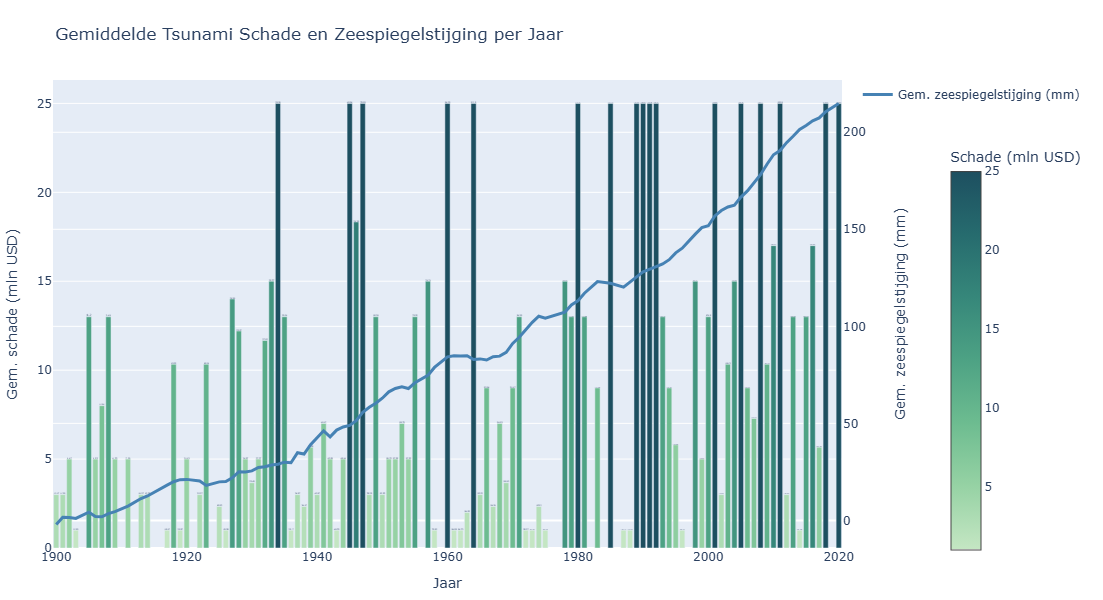

In [44]:
import pandas as pd
import numpy as np
import plotly.graph_objects as go
import re

# ------- 1. Parser voor schadebedragen -------
def parse_damage(val):
    if pd.isna(val):
        return np.nan
    val = val.upper().strip()

    if 'BILLION' in val or 'B' in val:
        nums = re.findall(r'\d+\.?\d*', val)
        if nums:
            return float(nums[0]) * 1000
    elif 'MILLION' in val or 'M' in val:
        nums = re.findall(r'\d+\.?\d*', val)
        if nums:
            return float(nums[0])
    elif 'LIMITED' in val or 'LIITED' in val or '<$1' in val:
        return 0.5
    else:
        nums = re.findall(r'\d+\.?\d*', val)
        if nums:
            return float(nums[0])

    return np.nan

# ------- 2. Kolommen hernoemen & schade omzetten -------
merged = merged.rename(columns={
    'year': 'YEAR',
    'mmfrom1993-2008average': 'Sea_Level_Change_mm'
})

merged['Estimated_Damage_MillionUSD'] = merged['DAMAGE_TOTAL_DESCRIPTION'].apply(parse_damage)

# ------- 3. Gemiddelden per jaar berekenen -------
bubble_data = merged.groupby('YEAR').agg({
    'Sea_Level_Change_mm': 'mean',
    'Estimated_Damage_MillionUSD': 'mean',
    'DAMAGE_TOTAL_DESCRIPTION': 'count'
}).reset_index().rename(columns={'DAMAGE_TOTAL_DESCRIPTION': 'Tsunami_Count'})

# Filter voor geldige waarden en max schade 15 miljoen
bubble_data = bubble_data.dropna(subset=['Sea_Level_Change_mm', 'Estimated_Damage_MillionUSD'])
bubble_data = bubble_data[bubble_data['Estimated_Damage_MillionUSD'] <= 100]

# ------- 4. Plot met bar (schade) + lijn (zeespiegel) -------
fig = go.Figure()

# Bar voor schade met aangepaste hover info én verplaatste colorbar
fig.add_trace(go.Bar(
    x=bubble_data['YEAR'],
    y=bubble_data['Estimated_Damage_MillionUSD'],
    name='',
    showlegend=False,
    marker=dict(
        color=bubble_data['Estimated_Damage_MillionUSD'],
        colorscale='blugrn',
        colorbar=dict(
            title='Schade (mln USD)',
            x=1.125,            # Iets naar rechts verplaatst
            y=0.425,             # Iets naar beneden (midden van de grafiek)
            xanchor='left',
            yanchor='middle',
            len=0.9           # Korte schaalbalk
        ),
        showscale=True
    ),
    hovertemplate=
        '<b>Jaar:</b> %{x}<br>'+
        '<b>Gem. schade:</b> %{y:.2f} mln USD<br>'+
        '<b>Aantal tsunami’s:</b> %{customdata}<br>'+
        '<b>Gem. zeespiegelstijging:</b> %{text:.2f} mm<br>',
    customdata=bubble_data['Tsunami_Count'],
    text=bubble_data['Sea_Level_Change_mm'],
))


# Lijn voor zeespiegel zonder markers, met eigen y-as
fig.add_trace(go.Scatter(
    x=bubble_data['YEAR'],
    y=bubble_data['Sea_Level_Change_mm'],
    name='Gem. zeespiegelstijging (mm)',
    yaxis='y2',
    mode='lines',  # alleen lijn, geen markers
    line=dict(color='steelblue', width=3),
    hoverinfo='none'  # hover info via bar, dus hier niet nodig
))

# Layout met twee y-assen
fig.update_layout(
    title='Gemiddelde Tsunami Schade en Zeespiegelstijging per Jaar',
    xaxis=dict(title='Jaar'),
    yaxis=dict(
        title='Gem. schade (mln USD)',
        rangemode='tozero'
    ),
yaxis2=dict(
    title='Gem. zeespiegelstijging (mm)',
    overlaying='y',
    side='right',
    rangemode='tozero',
    title_font=dict(
        size=14,
    ),
    title_standoff=30
),

    height=600,
    width=775,
    margin=dict(l=50, r=70, t=80, b=50)
)

fig.show()

De stijgende schadebedragen suggereren dat tsunami’s in staat zijn om steeds meer waardevolle infrastructuur en bebouwing te treffen. Een hoger zeeniveau kan ertoe leiden dat het water verder landinwaarts reikt en daardoor grotere gebieden beschadigt. Tegelijkertijd zorgt de groei van steden in kustregio’s ervoor dat de potentiële schade per gebeurtenis stijgt. Hoewel er meerdere factoren meespelen, sluit dit patroon aan bij het argument, een stijgende zeespiegel draagt bij aan het verergeren van de impact van tsunami’s. Plot 3 onderstreept daarmee de economische consequenties van klimaatverandering in kustgebieden. Ook in Plot 2 wordt zichtbaar hoe de verwoestende impact van tsunami’s is toegenomen onder invloed van een stijgende zeespiegel. De grafiek toont het aantal dodelijke slachtoffers en het aantal volledig verwoeste huizen per tsunami.

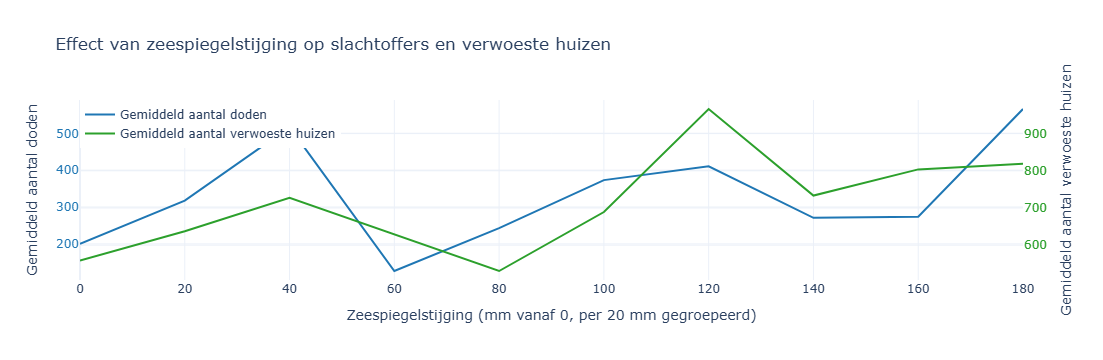

In [25]:
import pandas as pd
import plotly.graph_objs as go

# --- 1. Mapping naar numerieke doden ---
deaths_mapping = {
    "None reported": 0,
    "Few (~1 to 50 people)": 25,
    "Some (~51 to 100 people)": 75,
    "Many (~101 to 1,000 people)": 550,
    "Very Many (~1001 or more people)": 1500
}
houses_map = {
    'Few (~1 to 50 houses)': 25,
    'Some (~51 to 100 houses)': 75,
    'Many (~101 to 1000 houses)': 550,
    'Very Many (~1001 or more houses)': 1500
}
merged["HOUSES_ESTIMATED"] = merged["HOUSES_TOTAL_DESCRIPTION"].map(houses_map)
merged["DEATHS_ESTIMATED"] = merged["DEATHS_TOTAL_DESCRIPTION"].map(deaths_mapping)

# --- 2. Zeespiegel corrigeren ---
min_sea = merged["Sea_Level_Change_mm"].min()
merged["Sea_Level_Corrected"] = merged["Sea_Level_Change_mm"] - min_sea

# --- 3. Bepaal decennium (optioneel) ---
merged["Decennium"] = (merged["Year"] // 10) * 10

# --- 4. Groeperen per 20mm zeespiegelbin ---
merged["Sea_Level_Bin"] = (merged["Sea_Level_Corrected"] // 20) * 20
grouped = merged.groupby("Sea_Level_Bin").agg({
    "DEATHS_ESTIMATED": "mean",
    "HOUSES_ESTIMATED": "mean",
    "Year": lambda x: int(x.mean())  # gemiddeld jaar als representatie
}).reset_index()

# --- 5. Laatste bin verwijderen ---
max_bin = grouped["Sea_Level_Bin"].max()
grouped = grouped[grouped["Sea_Level_Bin"] < max_bin]

# --- 6. Plot maken ---
fig = go.Figure()
min_sea = merged["Sea_Level_Change_mm"].min()
merged["Sea_Level_Corrected"] = merged["Sea_Level_Change_mm"] - min_sea


merged["Sea_Level_Bin"] = (merged["Sea_Level_Corrected"] // 20) * 20
grouped = merged.groupby("Sea_Level_Bin").agg({
    "DEATHS_ESTIMATED": "mean",
    "HOUSES_ESTIMATED": "mean",
    "Year": lambda x: int(x.mean())  # gemiddeld jaar als representatie
}).reset_index()

# --- 5. Laatste bin verwijderen ---
max_bin = grouped["Sea_Level_Bin"].max()
grouped = grouped[grouped["Sea_Level_Bin"] < max_bin]


# Lijn: Aantal doden (blauwgroen tint)
fig.add_trace(go.Scatter(
    x=grouped["Sea_Level_Bin"],
    y=grouped["DEATHS_ESTIMATED"],
    name="Gemiddeld aantal doden",
    mode="lines",
    line=dict(color="#1f77b4"),  # steel blue / blauw tint
    hovertemplate=(
        "%{y:.0f}<br>"
    ),
    customdata=grouped[["Year"]].values
))

# Lijn: Aantal verwoeste huizen (groentint)
fig.add_trace(go.Scatter(
    x=grouped["Sea_Level_Bin"],
    y=grouped["HOUSES_ESTIMATED"],
    name="Gemiddeld aantal verwoeste huizen",
    mode="lines",
    line=dict(color="#2ca02c"),  # forest green / groen tint
    yaxis="y2",
    hovertemplate=(
        "%{y:.0f}<br>" +
        "Zeespiegelstijging: %{x:.0f} mm<br>" +
        "Gemiddeld jaar: %{customdata[0]:.0f}"
    ),
    customdata=grouped[["Year"]].values
))

# --- 7. Layout ---
fig.update_layout(
    title="Effect van zeespiegelstijging op slachtoffers en verwoeste huizen",
    xaxis=dict(title="Zeespiegelstijging (mm vanaf 0, per 20 mm gegroepeerd)"),
    yaxis=dict(
        title="Gemiddeld aantal doden",
        tickfont=dict(color="#1f77b4")  # zelfde blauw als lijn
    ),
    yaxis2=dict(
        title="Gemiddeld aantal verwoeste huizen",
        tickfont=dict(color="#2ca02c"),  # zelfde groen als lijn
        overlaying="y",
        side="right"
    ),
    legend=dict(x=0.00, y=1.),
    template="plotly_white",
    hovermode="x unified"
)

fig.show()


Opvalled is dat beide lijnen over het algemeen stijgen naarmate de zeespiegel toeneemt. Hoewel er schommelingen zichtbaar zijn, laten vooral de pieken bij 120 mm en 180 mm zeespiegelstijging een sterke toenama van verwoeste huizen zien. Het aantal slachtoffers vertoont een soortgelijk patroon, met een duidelijke piek bij 180 mm.
Deze gegevens suggereren dat een hogere zeespiegel niet alleen leidt tot meer schade, zoals te zien in plot 2 en 3, maar ook samenhangt met een hoger aantal slachtoffers.